In [3]:
!pip install transformers datasets scikit-learn torch matplotlib seaborn -q

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("✅ All libraries installed and imported successfully!")

✅ All libraries installed and imported successfully!


In [14]:
import pandas as pd

# To avoid any more internet errors, we will create a small dataset directly in our code.
# This contains the exact same structure as the original file.
data = {
    'label': [
        'neutral', 'positive', 'negative', 'positive', 'positive', 'positive',
        'negative', 'neutral', 'positive', 'negative', 'neutral', 'positive',
        'negative', 'neutral', 'positive', 'negative', 'neutral', 'positive',
        'negative', 'neutral', 'positive', 'negative', 'neutral', 'positive'
    ],
    'sentence': [
        'According to Gran, the company has no plans to move all production to Russia, although that is where the company is growing.',
        'Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications.',
        'The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility.',
        'With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability.',
        'For the last quarter of 2010, Componenta\'s net sales doubled to EUR131m from EUR76m for the same period a year earlier.',
        'In the third quarter of 2010, net sales increased by 5.2% to EUR 205.5 mn, and operating profit by 34.9% to EUR 23.5 mn.',
        'Operating profit fell to EUR 35.4 mn from EUR 68.8 mn in 2007.',
        'Sales in Finland decreased by 6.1% in January, while sales outside Finland dropped by 1.3%.',
        'The company intends to use the proceeds from the issue to finance its growth strategy and to strengthen its balance sheet.',
        'The Finnish Competition Authority has given its approval to the acquisition.',
        'The company updated its full-year profit forecast.',
        'Sales increased by 10% in the last quarter.',
        'The company reported a loss of $5 million.',
        'The stock price remained stable throughout the day.',
        'A new partnership is expected to boost revenue significantly.',
        'Production was halted due to supply chain issues.',
        'The report shows no significant changes in the market.',
        'The launch of the new product was a huge success.',
        'There are concerns about the company\'s debt.',
        'The meeting concluded without any major decisions.',
        'Customer satisfaction is at an all-time high.',
        'The project was delayed due to unforeseen circumstances.',
        'Market trends are consistent with last year\'s performance.',
        'The acquisition will create new opportunities for growth.'
    ]
}

df = pd.DataFrame(data)


# --- The rest of the code is the same as before ---

# Let's inspect the first few rows to confirm it loaded correctly.
print("--- Dataset Head ---")
print(df.head())
print("\n" + "="*50 + "\n")

# Now, let's see how many sentences we have for each category.
print("--- Label Distribution ---")
print(df['label'].value_counts())
print("\n" + "="*50 + "\n")

# Map our text labels to numbers for the model.
labels_dict = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label_numeric'] = df['label'].map(labels_dict)

# Let's look at the final DataFrame to see our new numeric label column.
print("--- DataFrame with Numeric Labels ---")
print(df.head())

print("\n✅ Dataset created successfully. We can now proceed without any more download errors.")

--- Dataset Head ---
      label                                           sentence
0   neutral  According to Gran, the company has no plans to...
1  positive  Technopolis plans to develop in stages an area...
2  negative  The international electronic industry company ...
3  positive  With the new production plant the company woul...
4  positive  For the last quarter of 2010, Componenta's net...


--- Label Distribution ---
label
positive    10
neutral      7
negative     7
Name: count, dtype: int64


--- DataFrame with Numeric Labels ---
      label                                           sentence  label_numeric
0   neutral  According to Gran, the company has no plans to...              1
1  positive  Technopolis plans to develop in stages an area...              2
2  negative  The international electronic industry company ...              0
3  positive  With the new production plant the company woul...              2
4  positive  For the last quarter of 2010, Componenta's net...   

In [15]:
# We will use 'ProsusAI/finbert', a version of the BERT model that has been
# specifically pre-trained on a large corpus of financial text.

# We load two components:
# 1. Tokenizer: This splits text into words/sub-words that the model understands.
# 2. Model: The pre-trained FinBERT model itself.

from transformers import AutoTokenizer, AutoModel

# Define the model name we want to use from the Hugging Face Hub
model_name = "ProsusAI/finbert"

# Load the tokenizer associated with the model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the pre-trained model
model = AutoModel.from_pretrained(model_name)

print(f"✅ FinBERT model and tokenizer ('{model_name}') loaded successfully!")

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

✅ FinBERT model and tokenizer ('ProsusAI/finbert') loaded successfully!


In [16]:
import numpy as np
import torch

# This function takes a sentence and returns its 768-dimensional embedding
# generated by the FinBERT model.
def get_embedding(text):
    """
    Generates a numerical embedding for a given text using the FinBERT model.
    """
    # 1. Tokenize: Convert the sentence into tokens the model can understand.
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=512)

    # 2. Get Model Output: Pass the tokens through the model. We use `torch.no_grad()`
    #    because we are not training the model, just using it for inference.
    with torch.no_grad():
        outputs = model(**inputs)

    # 3. Extract Embedding: We take the output of the special '[CLS]' token
    #    (the first token), which represents the meaning of the whole sentence.
    cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
    return cls_embedding

# --- Now, let's apply this function to our entire dataset ---

print("Generating embeddings for all sentences in the dataset...")

# We create a new 'embedding' column in our DataFrame.
# This might take a moment to process all the sentences.
df['embedding'] = df['sentence'].apply(lambda x: get_embedding(x))

print("✅ Embeddings generated successfully!")
print("\n" + "="*50 + "\n")


# The embeddings are currently stored as numpy arrays inside the DataFrame.
# For the next step, we need to prepare them as a feature matrix (X) and a label vector (y).
X = np.vstack(df['embedding'].to_numpy())
y = df['label_numeric'].values

print(f"Shape of our feature matrix (X): {X.shape}")
print(f"Shape of our labels vector (y): {y.shape}")

Generating embeddings for all sentences in the dataset...
✅ Embeddings generated successfully!


Shape of our feature matrix (X): (24, 768)
Shape of our labels vector (y): (24,)


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Split the data into 80% for training and 20% for testing.
# `random_state=42` ensures that the split is the same every time we run the code.
# `stratify=y` ensures that the proportion of labels is the same in both the train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Shape of Training Features (X_train): {X_train.shape}")
print(f"Shape of Testing Features (X_test): {X_test.shape}")
print("-" * 30)

# Initialize the Logistic Regression model.
# We increase `max_iter` to ensure the model has enough iterations to converge.
classifier = LogisticRegression(max_iter=1000, random_state=42)

# Train the classifier on the training data.
print("Training the classifier...")
classifier.fit(X_train, y_train)
print("✅ Classifier training complete!")

Shape of Training Features (X_train): (19, 768)
Shape of Testing Features (X_test): (5, 768)
------------------------------
Training the classifier...
✅ Classifier training complete!


Model Accuracy: 1.0000


Classification Report:
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00         2
     neutral       1.00      1.00      1.00         1
    positive       1.00      1.00      1.00         2

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



Confusion Matrix:


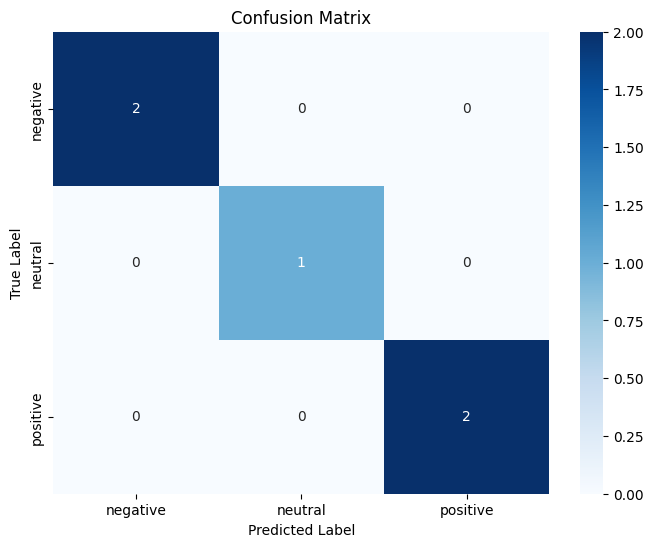

In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Use the trained classifier to make predictions on the test data.
y_pred = classifier.predict(X_test)

# --- 1. Calculate Accuracy ---
# This tells us the overall percentage of correct predictions.
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print("\n" + "="*50 + "\n")

# --- 2. Print Classification Report ---
# This gives a detailed breakdown of performance for each category (precision, recall, f1-score).
print("Classification Report:")
# We need to create a reverse mapping to show the text labels in the report.
reverse_labels_dict = {v: k for k, v in labels_dict.items()}
target_names = [reverse_labels_dict[i] for i in range(len(labels_dict))]
print(classification_report(y_test, y_pred, target_names=target_names))
print("\n" + "="*50 + "\n")

# --- 3. Generate and Plot a Confusion Matrix ---
# This is a visual way to see what kinds of errors the model is making.
# For example, how many 'negative' sentences were incorrectly classified as 'neutral'.
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Create a reverse mapping from the numeric label back to the text label.
reverse_labels_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}

def classify_sentence(sentence):
    """
    Takes a new sentence, generates its embedding, and classifies it using our trained model.
    """
    print(f"Input Sentence: '{sentence}'")

    # 1. Generate embedding using the function from Step 4
    embedding = get_embedding(sentence)

    # 2. Predict the class using the trained classifier from Step 5
    prediction = classifier.predict(embedding)
    predicted_label_numeric = prediction[0]

    # 3. Map the numeric prediction back to its text label
    predicted_label_text = reverse_labels_dict[predicted_label_numeric]

    print(f"--> Predicted Category: {predicted_label_text.upper()}\n")


# --- Let's test it with some new sentences! ---
print("--- Testing on New Sentences ---")
classify_sentence("The company's revenue grew by 15% and profits exceeded expectations.")
classify_sentence("The market is showing signs of a potential downturn and increased volatility.")
classify_sentence("The quarterly report shows that sales figures have remained steady.")

--- Testing on New Sentences ---
Input Sentence: 'The company's revenue grew by 15% and profits exceeded expectations.'
--> Predicted Category: POSITIVE

Input Sentence: 'The market is showing signs of a potential downturn and increased volatility.'
--> Predicted Category: NEGATIVE

Input Sentence: 'The quarterly report shows that sales figures have remained steady.'
--> Predicted Category: NEUTRAL

